<a href="https://colab.research.google.com/github/rawanamrrr/DeepLearning1/blob/main/Drowsiness_Detection_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rawanamrmohamed","key":"373a26c07b68a3afac39d5801874fba0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd

Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown
100% 2.58G/2.58G [00:35<00:00, 55.1MB/s]
100% 2.58G/2.58G [00:35<00:00, 78.8MB/s]


In [ ]:
!unzip /content/driver-drowsiness-dataset-ddd.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: /content/Dri

In [ ]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator as data_augment
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization,TimeDistributed,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers as layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
data_d = "/content/Driver Drowsiness Dataset (DDD)"
output_d = '/kaggle/working/splitted_Data'

splitfolders.ratio(data_d, output=output_d, seed=1942, ratio=(.8, .15, .05))

Copying files: 41793 files [00:39, 1059.88 files/s]


In [ ]:
traind = "/kaggle/working/splitted_Data/train"
testd = "/kaggle/working/splitted_Data/test"
vald = "/kaggle/working/splitted_Data/val"

In [ ]:
train_datagen = data_augment(rescale=1./255)
test_datagen = data_augment(rescale=1./255)
val_datagen = data_augment(rescale=1./255)

In [ ]:
train_batches = train_datagen.flow_from_directory(
    traind,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
test_batches = test_datagen.flow_from_directory(
    testd,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)
val_batches = val_datagen.flow_from_directory(
    vald,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


In [ ]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({0: 17878, 1: 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({0: 1118, 1: 973})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({0: 3352, 1: 2916})


Pixels of the tenth image after Normalization: 

[[[0.09411766 0.10196079 0.10588236]
  [0.08235294 0.09019608 0.09411766]
  [0.06666667 0.07843138 0.08627451]
  ...
  [0.09803922 0.14509805 0.17254902]
  [0.09803922 0.14509805 0.17254902]
  [0.09803922 0.14509805 0.17254902]]

 [[0.07058824 0.07843138 0.08235294]
  [0.0627451  0.07058824 0.07843138]
  [0.05882353 0.06666667 0.07843138]
  ...
  [0.09803922 0.14117648 0.1764706 ]
  [0.09803922 0.14117648 0.1764706 ]
  [0.09803922 0.14117648 0.1764706 ]]

 [[0.04705883 0.05882353 0.0627451 ]
  [0.04705883 0.05882353 0.0627451 ]
  [0.04705883 0.05882353 0.06666667]
  ...
  [0.09803922 0.13725491 0.18039216]
  [0.09803922 0.13725491 0.18039216]
  [0.09803922 0.13725491 0.18039216]]

 ...

 [[0.26666668 0.20392159 0.18039216]
  [0.28627452 0.22352943 0.20000002]
  [0.3137255  0.24705884 0.22352943]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.2784314  0.21176472 

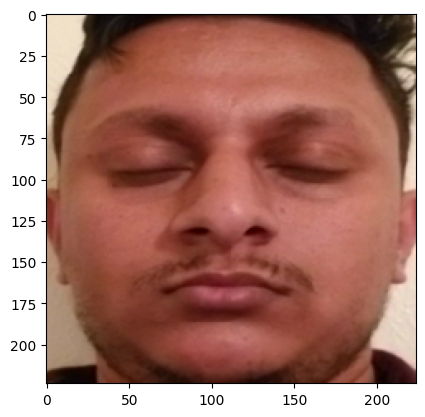

In [ ]:
images, labels = next(train_batches)
print(f"Pixels of the tenth image after Normalization: \n\n{images[0]}")
plt.imshow(images[9])
plt.show()

In [ ]:
print(f"there are { images[9].ndim} Channels ")
print(f"image shape : {images[9].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


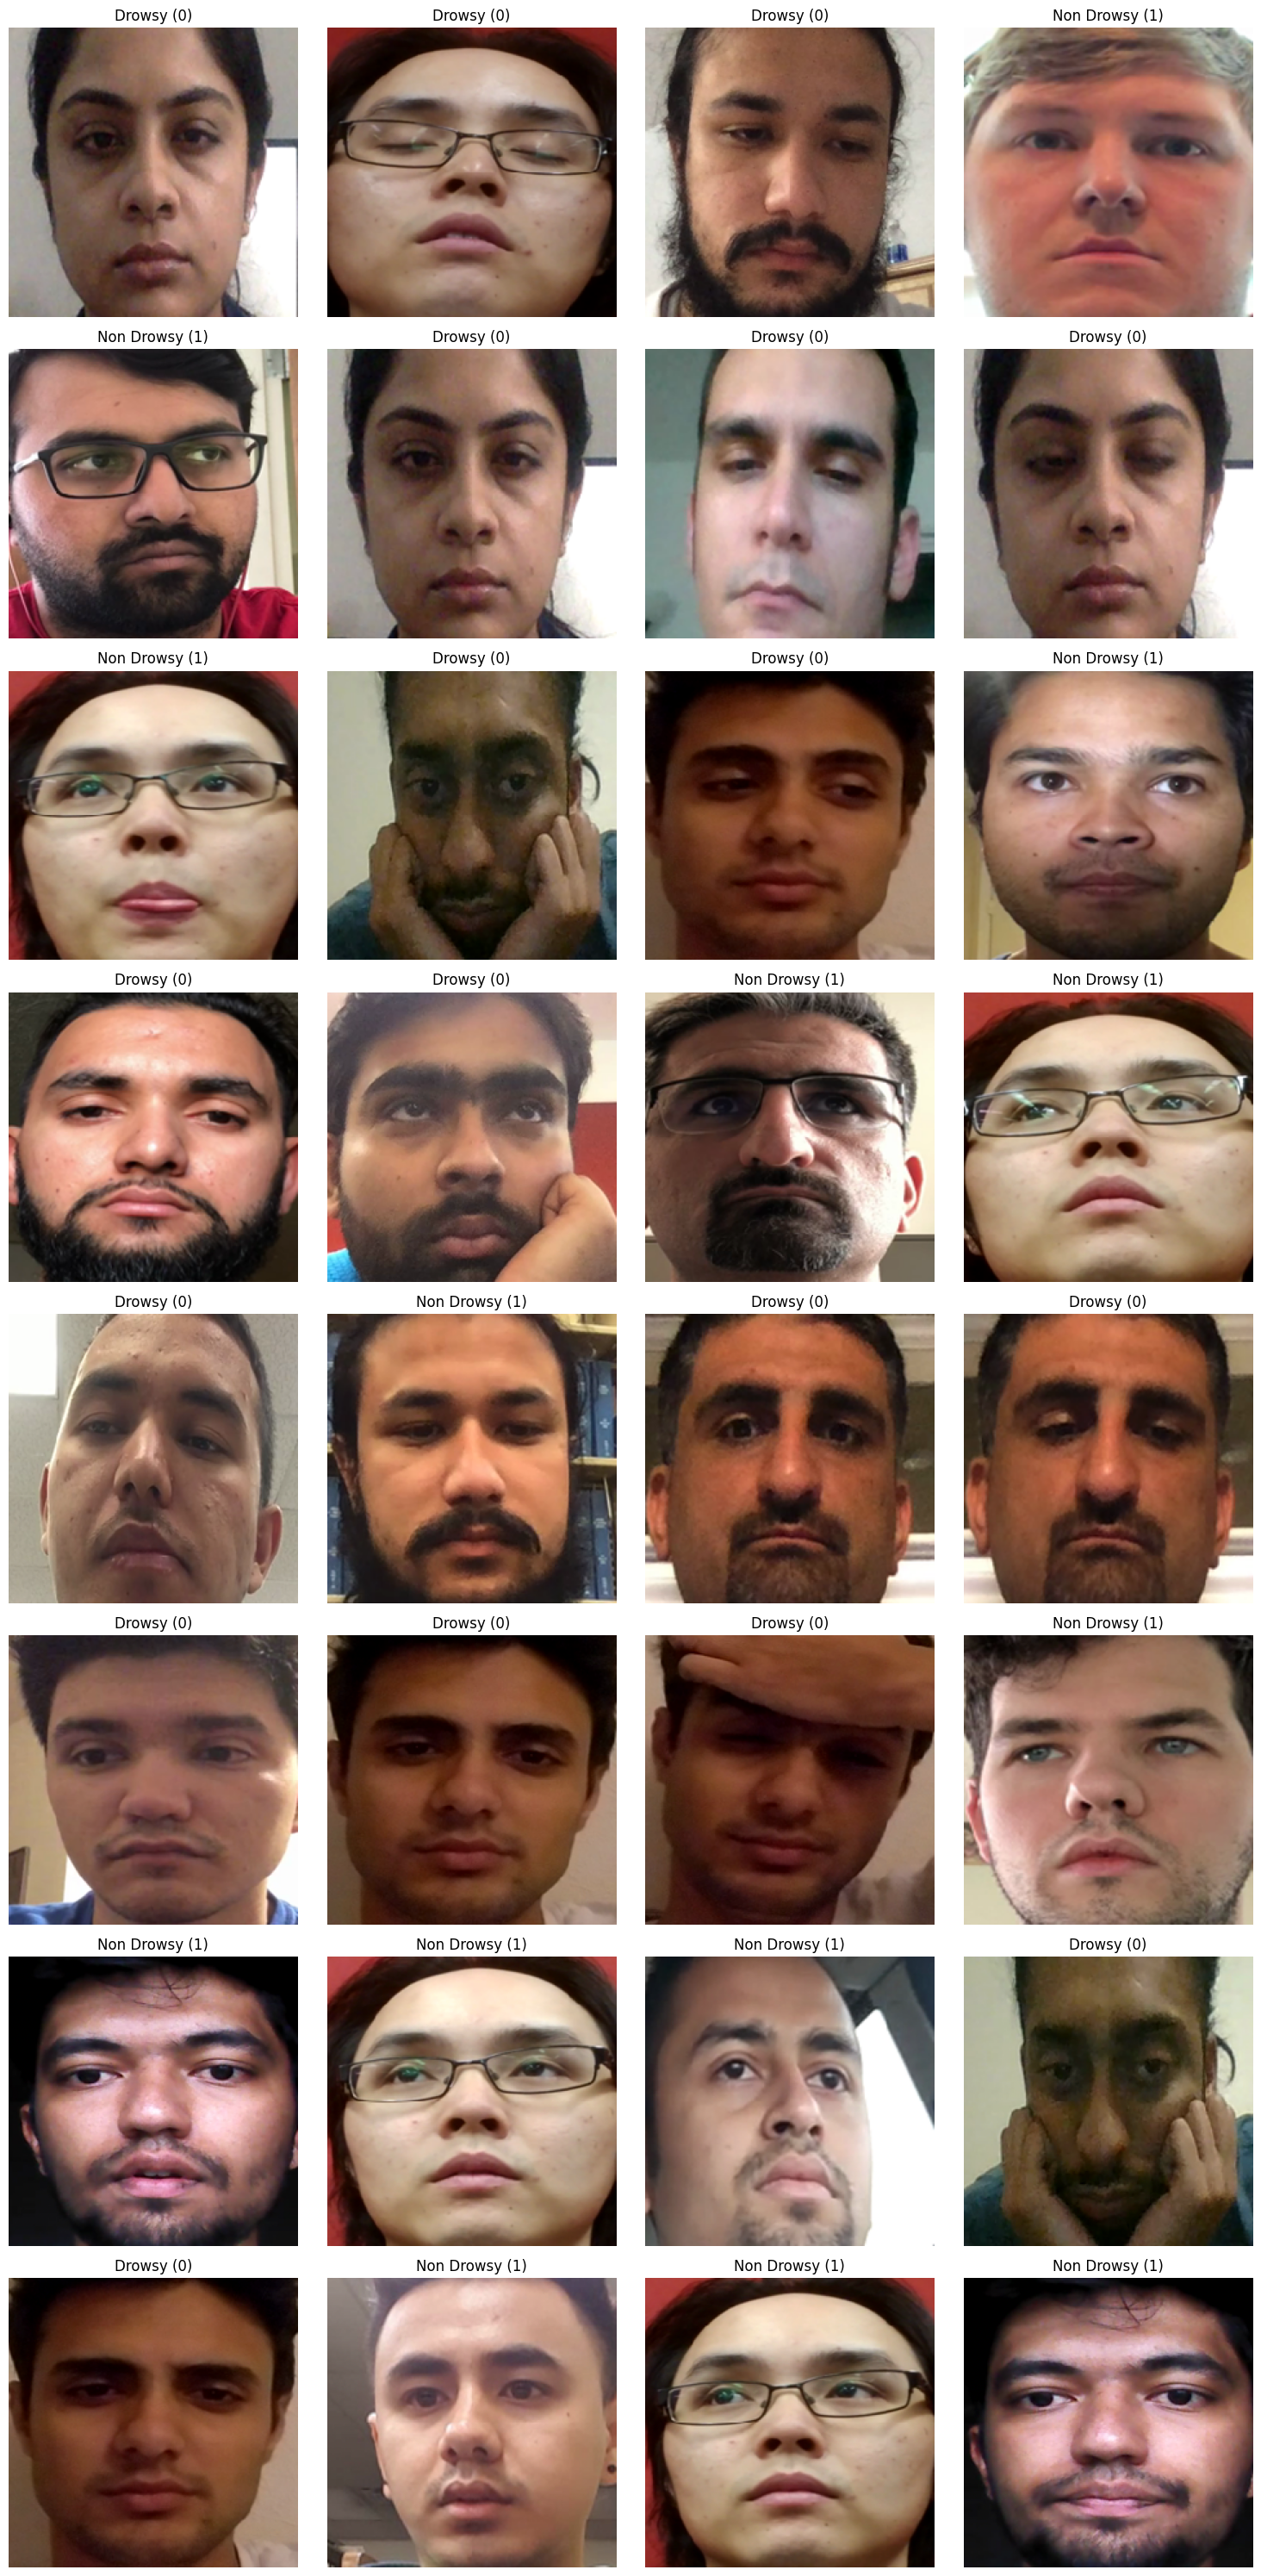

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [ ]:
model_base = keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape = (224, 224, 3)
)
model_base.trainable=False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = model_base.output
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Flatten()(x)
preds = Dense(2, activation='softmax')(x)
CNNLSTM = Model(inputs=model_base.input, outputs=preds)


In [ ]:
CNNLSTM.compile(optimizer=Adam(0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = CNNLSTM.fit(train_batches, epochs = 2, validation_data = val_batches, batch_size=32)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 8103s 4s/step - accuracy: 0.9840 - loss: 0.0488 - val_accuracy: 0.9997 - val_loss: 6.2389e-04
Epoch 2/2
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 8047s 4s/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 9.6154e-05


In [ ]:
train_loss, train_acc = CNNLSTM.evaluate(train_batches)

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 6153s 3s/step - accuracy: 1.0000 - loss: 1.5931e-04


In [ ]:
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc*100:.2f}%")

Training Loss: 0.0001
Training Accuracy: 100.00%


In [ ]:
test_loss, test_accuracy = CNNLSTM.evaluate(test_batches)

In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.0006
Test Accuracy: 99.95%


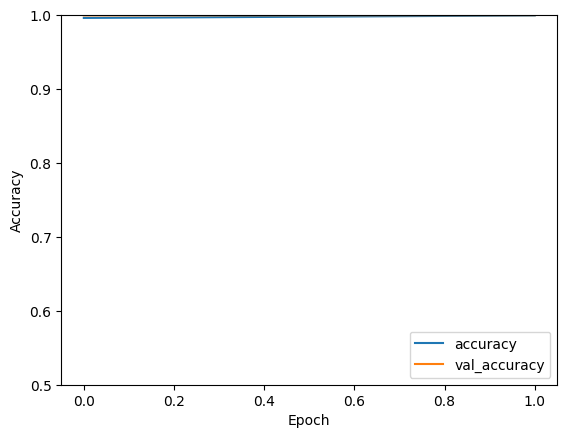

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss = history.history['loss']
epochs_range = range(10)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
CNNLSTM.save('cnn_lstm1.h5')